# Loading Packages & Initialization

reference : https://gist.github.com/mertedali/ab7078b9c29dea18c72525239d636b96

In [2]:
rm(list=ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs) # For maximin Latin hypercube sampling
library(ggplot2)
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr) # for evaluating predictive power

options(warn = -1)

In [3]:
# Select if data generation is wanted
GenerateTTData <- 0

In [4]:
Is_Headless <- 0
nl.model <- "Segregation"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
model.path <- paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/",nl.model,".nlogo")

if (Is_Headless == 0){
    NLStart(nl.path, gui = TRUE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    } else {
    NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    
    #NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar', nl.obj = nl.model)
    #NLLoadModel (model.path, nl.obj = nl.model )
    }

# Model Parameters & Functions

## Set model parameters

In [5]:
set.seed(1)

## Set model parameters
 # Number of replications for each instance
nofrep = 10     
 # order feature names according to their definition order in run_model
feature_names = c("density","%-similar-wanted")  
 # 
output_name = c("percent-similar")

 # Number of input parameters of the agent-based model
nofparams = length(feature_names)      

# set RF parameters
ntree = 400
mtry = 2

## Set user parameters

In [10]:
error_type = "RMSE" # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "sd" #, "range" 

unlabeled_ins = 700 
test_ins = 700
train_ins_oneshot = 700
train_ins_Ad = 200

# Set selection parameters
selected_ins = 5 #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1 # number of variables eliminated in each step


## Define functions

In [11]:
#run_model <- function(feature_names,feature_values){ # both should be in character list format
run_model <- function(feature_values){ # both should be in character list format

    
    k = length(feature_names)    
    for(i in 1:k){
        NLCommand(paste0("set ",feature_names[i]," ",feature_values[i]))      
    }
    NLCommand("setup")
    NLDoCommand(100, "go") 
    result <- NLReport(output_name)
    return(result)   
}

In [12]:
#run_replicas <- function(nofrep,feature_names,feature_values) {
run_replicas <- function(nofrep,feature_values) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1) # Save the result of each replication
    for(i in 1:nofrep){
     #   replicas[i]= run_model(feature_names,feature_values)
        replicas[i]= run_model(feature_values)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}

In [13]:
#run_ABM = function(nofrep,nofinstances,unlabeledset,featurenames = feature_names){
run_ABM = function(nofrep,nofinstances,unlabeledset){
   #unlabeledset = setcolorder(unlabeledset,featurenames) 
   unlabeledset = setcolorder(unlabeledset,feature_names) 
   for(i in 1:nofinstances){
        #unlabeledset[i, output :=  run_replicas(nofrep,featurenames, as.matrix(unlabeledset[i,]))]    
        unlabeledset[i, output :=  run_replicas(nofrep, as.matrix(unlabeledset[i,]))] 
    } 
    return(unlabeledset)
}


In [14]:
#error functions on test data
rmse_func <- function(actual, predicted){
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual,predicted){
    return( (abs(actual - predicted)/ actual)*100 )
}

bias_func <- function(actual,predicted){
    return( (actual - predicted)/ actual )
}

#error functions on train data
obb_error_func <- function(model){
   if(model$type == "regression"){
        oob_error = model$mse[model$ntree] 
    }else if(model$type == "classification"){
        oob_error = model$err.rate 
    } 
    return(oob_error)
}


In [15]:
# prediction functions
get_test_predictions <- function(model,testset,errortype){
    
    predictedLabels <- predict(model, testset)
    predictedLabels <- cbind(testset,predictedLabels)
    setnames(predictedLabels, "predictedLabels","pred_output")

    output_variables = colnames(select(predictedLabels, contains("output")))
    # output_variables[1] = true output
    # output_variables[2] = predicted output
    
    #output_variables = colnames(predictedLabels[,1:(ncol(predictedLabels) - 2)])
    
    if(error_type == "MAPE"){
        predictedLabels[,MAPE := mapply(function(x,y) mape_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "RMSE"){
        predictedLabels[,RMSE := mapply(function(x,y) rmse_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "BIAS"){
        predictedLabels[,BIAS := mapply(function(x,y) bias_func(x,y),get(output_variables[1]),get(output_variables[2]))]
           } 
                                  
     output_variables_1 = predictedLabels[,get(output_variables[1]), with = TRUE]
     output_variables_2 = predictedLabels[,get(output_variables[2]), with = TRUE]
    
     performance_temp = matrix(c(1:4), nrow = 1, ncol = 4)
     performance_temp[1] = 1 #t ################
     performance_temp[2] =  mae(output_variables_1 , output_variables_2)
     performance_temp[3] = rmse(output_variables_1 , output_variables_2)
     performance_temp[4] = mape(output_variables_1 , output_variables_2)
    
    return(list(predictedLabels,performance_temp,output_variables))
    
} 

In [57]:
# Adaptive sample selection function with an uncertainty measure depending on "selection_metric"
sample_selection <- function(selected_ins,unlabeled_set,datax,datay){

    rf <- randomForest(x = datax, y = datay, importance = TRUE ,ntree = ntree, mtry = mtry )
    ind_pred <- t(predict(rf, unlabeled_set,predict.all = TRUE)$individual) %>% data.table() # predictions by each tree in the forest
    
    ind_pred_eval = data.table()
    
    # standard deviation calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev,".","sd")
    ind_pred_eval = cbind(ind_pred_eval,s_dev)
    
    # range calculation
    range = sapply(ind_pred, range) %>% t() %>% data.table()
    range = range[,.(range = abs(range[,1] - range[,2]))]
    setnames(range,"range.V1","range")
    ind_pred_eval = cbind(ind_pred_eval,range)
    
    ind_pred_eval[,idx := 1:.N]
    
    if(selection_metric == "sd") {
      ind_pred_eval = ind_pred_eval[order(-sd)][1:selected_ins]
    }else if(selection_metric == "range"){
      ind_pred_eval = ind_pred_eval[order(-range)][1:selected_ins]
    }
    
    unlabeled_set[,idx := 1:.N]    
    train_candidates = unlabeled_set[ind_pred_eval$idx]
    
    return(train_candidates)
}


In [17]:
# Random sample selection
random_sample_selection <- function(selected_ins,unlabeled_set){
  
    unlabeled_set[,idx := 1:.N]
    
    train_candidate_idx = sample(unlabeled_set$idx, selected_ins, replace = FALSE, prob = NULL)   
    train_candidates = unlabeled_set[idx %in% train_candidate_idx]
    
    return(train_candidates)
}

In [18]:
get_variable_importance <- function(model){
    importances <- importance(model, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ranked_features = feature_names[selected.vars]
    ordered.importances <- importances[selected.vars]
    
    return(ranked_features)
}                      

In [19]:
# Define functions
### make sure run this line only once, or in odd numbers (3,5,7..) ###
feature_elimination <- function(h,nofEliminatedVariables,data,variableorder){ 
   # feature number
    setcolorder(data,variableorder)
    p <- ncol(data[,-c("output")]) 
    columns_left = colnames(data[, 1:c(1:(p - nofEliminatedVariables - h))])
           
    return(list(columns_left, h + nofEliminatedVariables))  
}

# Generate Unlabeled Data Pool

## Latin hyper cube sampling

In [20]:
if(GenerateTTData == 1){
    unlabeled_pool = as.data.table(maximinLHS(n = unlabeled_ins, k = nofparams, dup = 5))
    
    unlabeled_pool$V1 = qunif(unlabeled_pool$V1, 10, 90) 
    unlabeled_pool$V2 = qunif(unlabeled_pool$V2, 10, 90) 
    setnames(unlabeled_pool, c("V1","V2"), feature_names)
    
    unlabeled_pool[,idx := 1:.N]
        
    fwrite(unlabeled_pool, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_",Sys.Date(),".csv"))
}else{
    unlabeled_pool <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_04122019.csv")   
    unlabeled_pool <- head(unlabeled_pool[`%-similar-wanted` < 90 & `density` < 90],700)
}

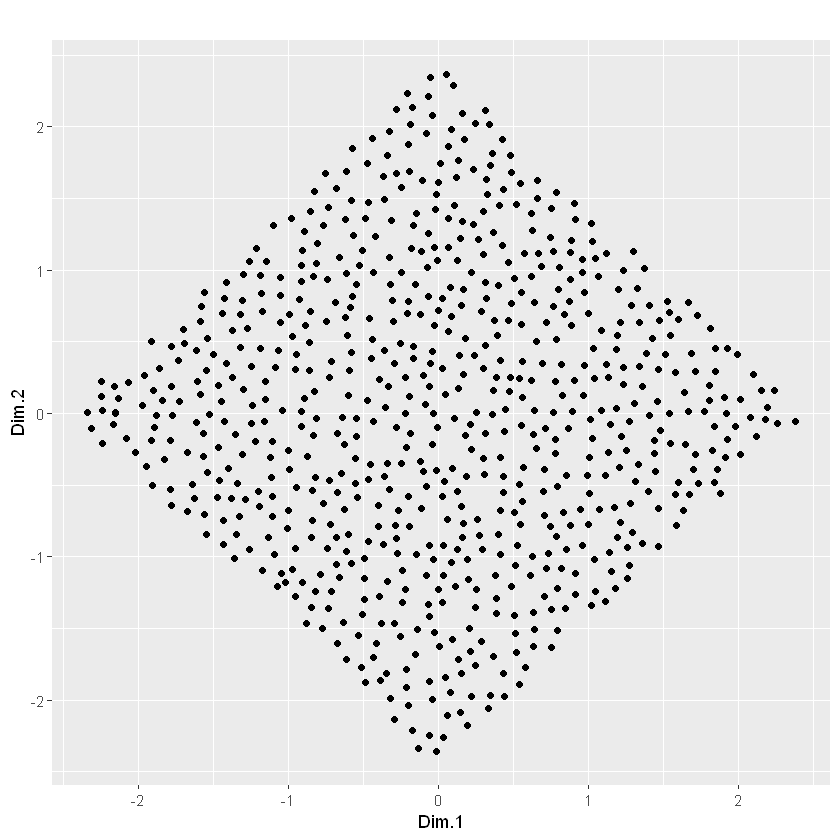

In [21]:
pca_unlabeled_pool <- princomp(unlabeled_pool[,-c("idx")], cor = TRUE, scores = TRUE)
pca_unlabeled_pool_components <- get_pca_ind(pca_unlabeled_pool)
p_unlabeled_pool <- ggplot(data = data.table(pca_unlabeled_pool_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_unlabeled_pool


# Generate Test Set

In [22]:
if(GenerateTTData == 1){
    test_set <- head(unlabeled_pool,test_ins)
    
    ################## Buraya variale'ların datatipine göre bir şeyler yazılabilir
    test_set$density = runif(test_ins, 10, 90) 
    test_set$`%-similar-wanted` = runif(test_ins, 10, 90) 
    test_set[,c("idx"):= NULL]
      
    paste0("ABM run start time : ",Sys.time())
    test_set = run_ABM(nofrep,test_ins,test_set) %>% as.data.table()
    paste0("ABM run end time : ",Sys.time())
    
    fwrite(test_set, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_",Sys.Date(),".csv"))
}else{
    test_set <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_04122019.csv")  
    test_set <- head(test_set[`%-similar-wanted` < 90],800)

}

10 * 10 ~ 1 min
100 * 10 ~ 14 min
900 * 10 ~ 09:16 -- 2019-12-03 07:54:10 +03"

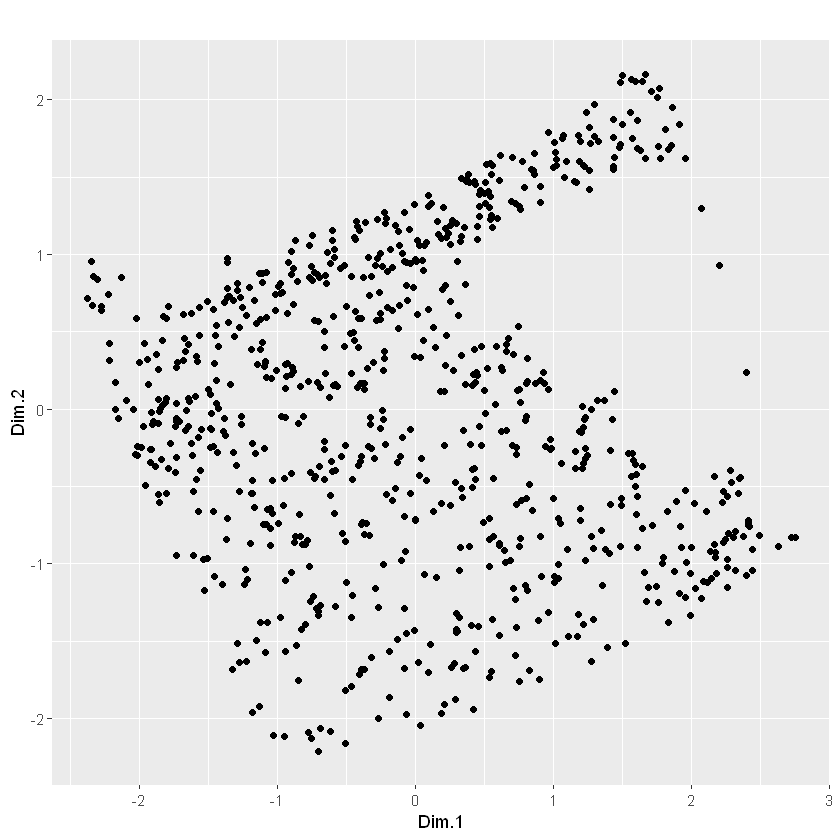

In [23]:
pca_test_set <- princomp(test_set, cor = TRUE, scores = TRUE)
pca_test_set_components <- get_pca_ind(pca_test_set)
p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_test_set

# Benchmark : One-shot sampling, No feature elimination

## Generate Training Set

Select a very big data pool ( nofinstances should be very high ) , like 1000

In [24]:
if(GenerateTTData == 1){
    LHSample = as.data.table(maximinLHS(n = train_ins_oneshot, k = nofparams, dup = 5))
    
    LHSample$V1 = qunif(LHSample$V1, 10, 90) 
    LHSample$V2 = qunif(LHSample$V2, 10, 90) 
    setnames(LHSample, c("V1","V2"), feature_names)
    
    LHSample$output <- 0.00
    
    paste0("ABM run start time : ",Sys.time())
    LHSample = run_ABM(nofrep,train_ins_oneshot,LHSample) %>% as.data.table()
    paste0("ABM run end time : ",Sys.time())
    
    fwrite(LHSample, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data",Sys.Date(),".csv"))
    
}else{
    LHSample <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_04122019.csv")
    LHSample <- head(LHSample[`%-similar-wanted` < 90],700)
}

### Visualization

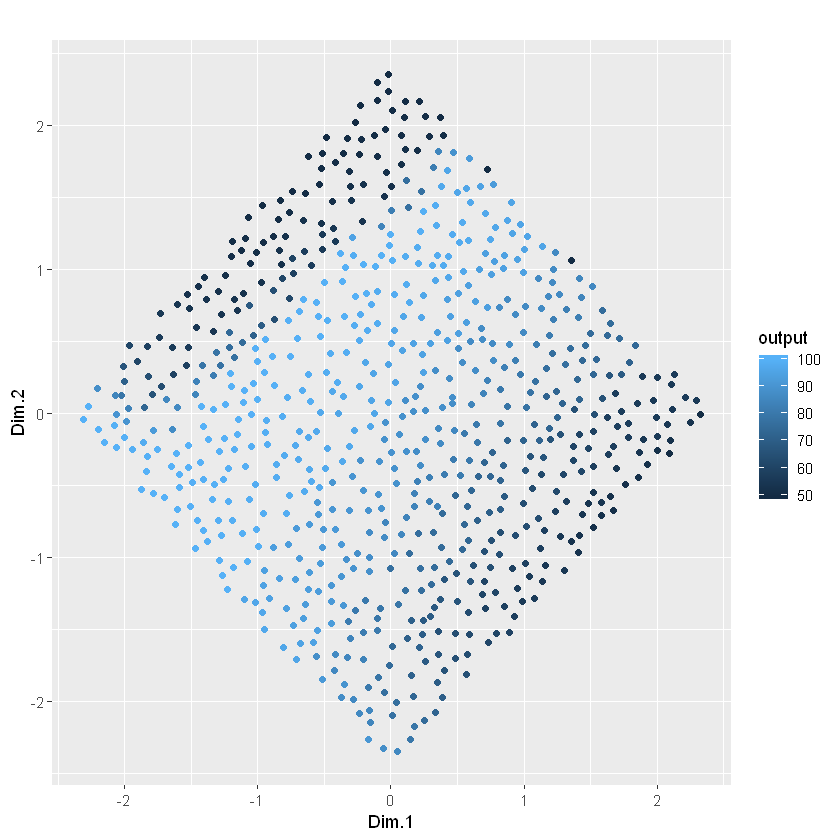

In [26]:
pca_LHSample <- princomp(LHSample[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_components <- get_pca_ind(pca_LHSample)
pca_LHSample_components <-cbind(pca_LHSample_components$coord[,1:2],LHSample[,.SD, .SDcols = c("output")])
p_LHSample <- ggplot(data = pca_LHSample_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_LHSample

## Train & Test Metamodel

In [27]:
model_oneshot <- randomForest(x = LHSample[, -c("output")], y = LHSample$output, importance = TRUE,ntree = ntree, mtry = mtry)
model_oneshot


Call:
 randomForest(x = LHSample[, -c("output")], y = LHSample$output,      ntree = ntree, mtry = mtry, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 400
No. of variables tried at each split: 2

          Mean of squared residuals: 9.161969
                    % Var explained: 96.96

In [28]:
obb_error_oneshot <- obb_error_func(model_oneshot)

In [ ]:
#OBB_pred = cbind(LHSample$output,model_oneshot$predicted)
#names(OBB_pred) <- c("actual","predicted")

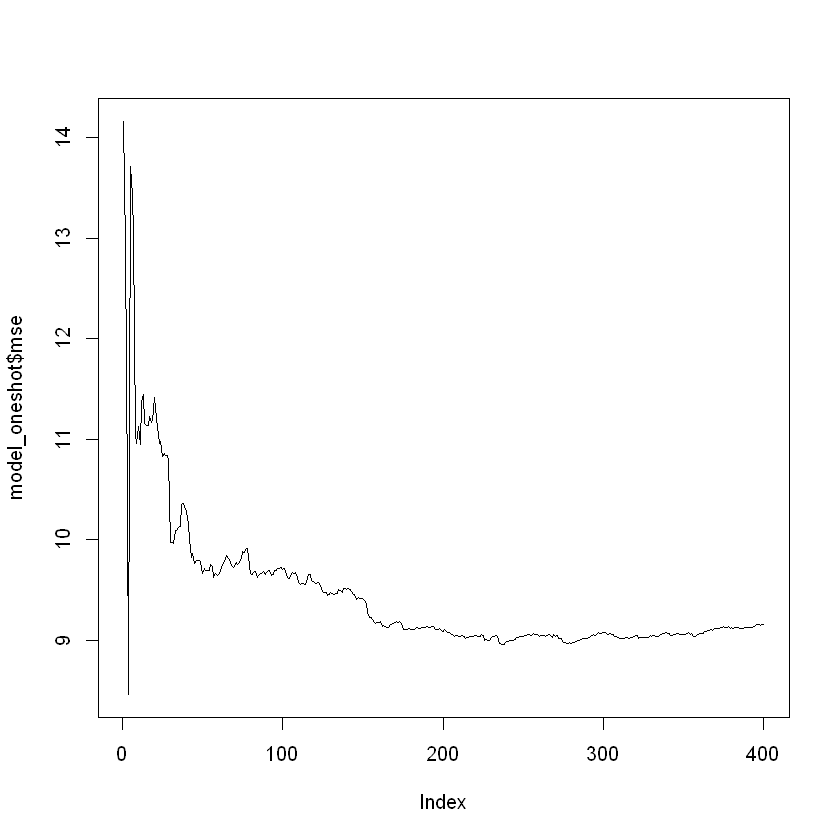

In [29]:
plot(model_oneshot$mse, type="l")

In [30]:
test_prediction_oneshot = get_test_predictions(model_oneshot,test_set,error_type)
predictedLabels_oneshot = test_prediction_oneshot[[1]]

performance_table_oneshot = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())

performance_table_temp = test_prediction_oneshot[[2]]
performance_table_oneshot = rbind(performance_table_oneshot,performance_table_temp, use.names = FALSE)
rm(performance_table_temp)   

output_variables = test_prediction_oneshot[[3]]    


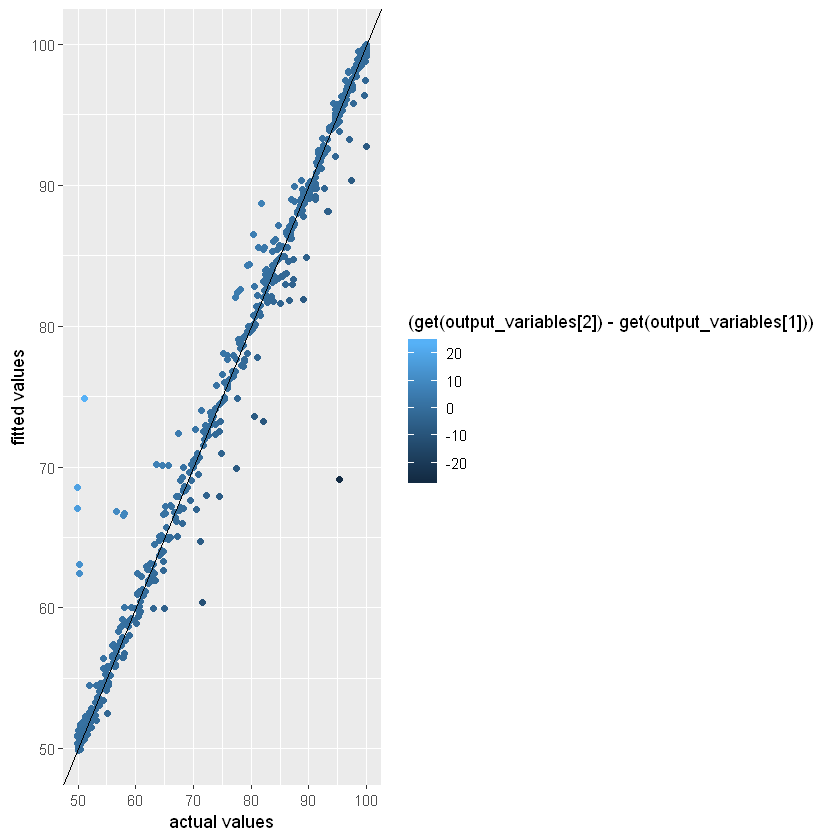

In [31]:
p_oneshot <- ggplot(predictedLabels_oneshot,aes(x = get(output_variables[1]), y = get(output_variables[2]), color = (get(output_variables[2]) - get(output_variables[1])))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values")

p_oneshot

# Random Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [32]:
if(GenerateTTData == 1){
   
    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
    
    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
    setnames(LHSample_Ad, c("V1","V2"), feature_names)
    LHSample_Ad$output <- 0.00
    
    paste0("ABM run start time : ",Sys.time())
    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
    paste0("ABM run end time : ",Sys.time())
    
    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))

}else{
    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90  & `density` < 90],200)

}

## Train & Test Metamodel

In [33]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )

#error_type = "mape"  
predictedLabels_table = copy(test_set)

In [34]:
iter = 1

while(iter < 20){ 
    
    print(iter)

    trainx = LHSample_Ad[,.SD, .SDcols = feature_names]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){ # keep just as info
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    if(iter == 1){
        obb_error <- as.data.table(obb_error_func(model_Sub)) 
        obb_error$iter <- 1 
        setnames(obb_error,"V1","obb_error")
    }else{
         ## OOB Error & Test Error 
        obb_error_Sub <- as.data.table(obb_error_func(model_Sub)) 
        obb_error_Sub$iter <- iter 
        obb_error <- rbind(obb_error,obb_error_Sub, use.names = FALSE)
        rm(obb_error_Sub)
    }
 
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table_temp = test_predictions_Sub[[2]]
    performance_table_temp[[1]] = iter
    performance_table = rbind(performance_table,performance_table_temp, use.names = FALSE)
    rm(performance_table_temp)   
    
    output_variables = test_predictions_Sub[[3]]          

    # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = random_sample_selection(selected_ins,unlabeled_set)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    paste0("ABM train_candidate run start time : ",Sys.time())
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    paste0("ABM train_candidate run end time : ",Sys.time())
    
    if(iter == 1){
        train_candidates_table <- copy(train_candidates)
        train_candidates_table$iter <- iter
    }else{
        train_candidates_temp <- copy(train_candidates)
        train_candidates_temp$iter <- iter
        
        train_candidates_table <- rbindlist(list(train_candidates_table,train_candidates_temp), use.names=TRUE)
        rm(train_candidates_temp)
    }

    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])

    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19


In [35]:
# Final records
FinalTrainData_Rd = copy(LHSample_Ad)
performance_table_Rd = copy(performance_table)
train_candidates_table_Rd  = copy(train_candidates_table)
predictedLabels_table_Rd = copy(predictedLabels_table)
obb_error_Rd = copy(obb_error)

In [36]:
# show results
nrow(FinalTrainData_Rd)
performance_table_Rd 
train_candidates_table_Rd  
head(predictedLabels_table_Rd)
obb_error_Rd

[1] 295

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,2.084160,4.579301,3.026346
2,2.037959,4.489061,2.972927
3,1.968079,4.391375,2.884604
4,1.923673,4.269769,2.803342
5,1.917569,4.272107,2.794694
6,1.922500,4.295827,2.807313
7,1.895890,4.268259,2.779588
8,1.815036,4.190170,2.652540
9,1.805057,4.208668,2.639909


density,%-similar-wanted,idx,output,iter
<dbl>,<dbl>,<int>,<dbl>,<dbl>
15.58944,11.77994,83,81.23764,1
13.42041,36.25440,311,96.11373,1
81.23824,39.67071,518,80.72336,1
13.97423,87.50010,555,100.00000,1
25.86486,51.16387,607,98.82730,1
58.22955,35.47621,13,81.31989,2
18.79723,79.67726,468,96.29267,2
43.28615,82.95672,471,54.59197,2
29.26148,78.01998,504,82.83702,2


ERROR: Error in head(predictedLabels_table_rd): object 'predictedLabels_table_rd' not found


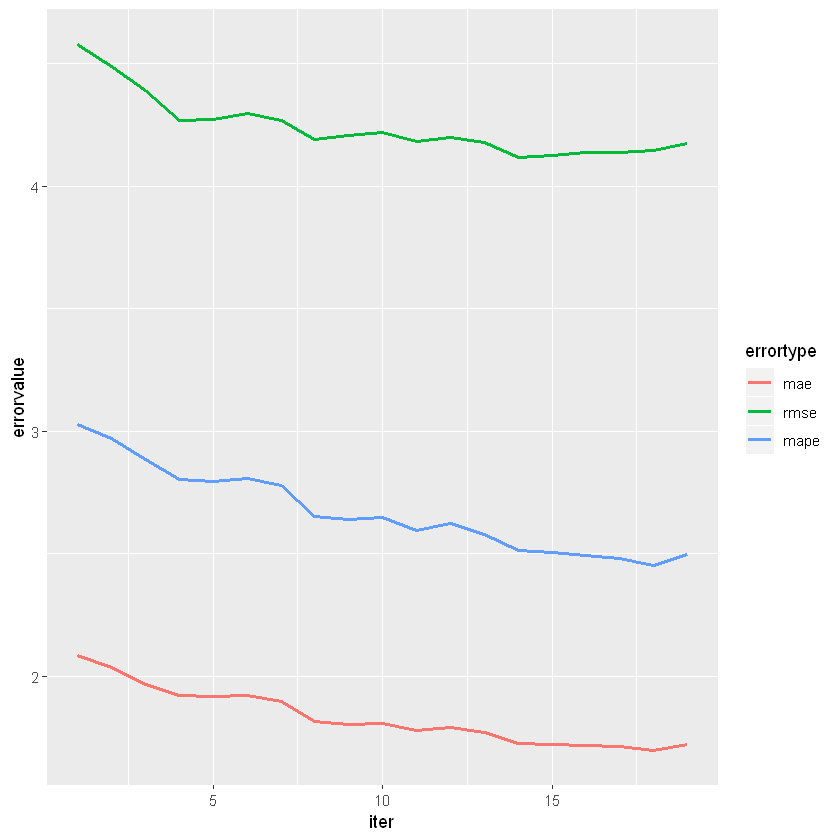

In [78]:
performance_molten_Rd <- melt(data = performance_table_Rd
                             , id.vars = 'iter')
setnames(performance_molten_Rd, c("variable","value"),c("errortype","errorvalue"))
p_Rd = ggplot(performance_molten_Rd, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
          geom_line(lwd=1)
p_Rd

# Adaptive Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [37]:
if(GenerateTTData == 1){
   
    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
    
    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
    setnames(LHSample_Ad, c("V1","V2"), feature_names)
    LHSample_Ad$output <- 0.00
    
    paste0("ABM run start time : ",Sys.time())
    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
    paste0("ABM run end time : ",Sys.time())
    
    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))

}else{
    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90  & `density` < 90],200)

}

### Visualization

In [38]:
pca_LHSample_Ad <- princomp(LHSample_Ad[,-c("output")], cor = TRUE, scores = TRUE)

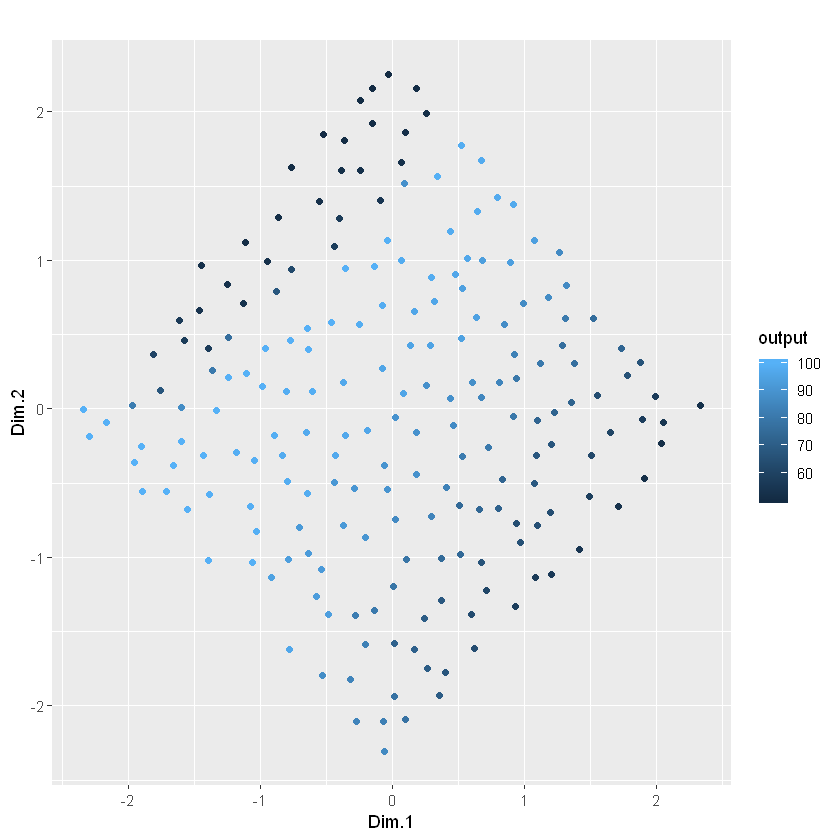

In [39]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_Ad_components <- get_pca_ind(pca_LHSample_Ad)
pca_LHSample_Ad_components <-cbind(pca_LHSample_Ad_components$coord[,1:2],LHSample_Ad[,c("output")])
p_LHSample_Ad <- ggplot(data = pca_LHSample_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_LHSample_Ad

## Train & Test Metamodel

In [40]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )

#error_type = "mape"  
predictedLabels_table = copy(test_set)

In [58]:

iter = 1

print(Sys.time())
while(iter < 20){ 
    
    print(iter)

    trainx = LHSample_Ad[,.SD, .SDcols = feature_names]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){ # keep just as info
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    if(iter == 1){
        obb_error <- as.data.table(obb_error_func(model_Sub)) 
        obb_error$iter <- 1 
        setnames(obb_error,"V1","obb_error")
    }else{
         ## OOB Error & Test Error 
        obb_error_Sub <- as.data.table(obb_error_func(model_Sub)) 
        obb_error_Sub$iter <- iter 
        obb_error <- rbind(obb_error,obb_error_Sub, use.names = FALSE)
        rm(obb_error_Sub)
    }
 
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table_temp = test_predictions_Sub[[2]]
    performance_table_temp[[1]] = iter
    performance_table = rbind(performance_table,performance_table_temp, use.names = FALSE)
    rm(performance_table_temp)   
    
    output_variables = test_predictions_Sub[[3]]          

    # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = sample_selection(selected_ins,unlabeled_set,trainx,trainy)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    print(paste0("ABM train_candidate run start time : ",Sys.time()))
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    print(paste0("ABM train_candidate run end time : ",Sys.time()))
    
    if(iter == 1){
        train_candidates_table <- copy(train_candidates)
        train_candidates_table$iter <- iter
    }else{
        train_candidates_temp <- copy(train_candidates)
        train_candidates_temp$iter <- iter
        
        train_candidates_table <- rbindlist(list(train_candidates_table,train_candidates_temp), use.names=TRUE)
        rm(train_candidates_temp)
    }

    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])

    iter = iter + 1
}
print(Sys.time())
# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!


[1] "2019-12-20 01:38:28 +03"
[1] 1
[1] "ABM train_candidate run start time : 2019-12-20 01:38:29"
[1] "ABM train_candidate run end time : 2019-12-20 01:40:48"
[1] 2
[1] "ABM train_candidate run start time : 2019-12-20 01:40:48"
[1] "ABM train_candidate run end time : 2019-12-20 01:43:48"
[1] 3
[1] "ABM train_candidate run start time : 2019-12-20 01:43:48"
[1] "ABM train_candidate run end time : 2019-12-20 01:46:47"
[1] 4
[1] "ABM train_candidate run start time : 2019-12-20 01:46:48"
[1] "ABM train_candidate run end time : 2019-12-20 01:49:45"
[1] 5
[1] "ABM train_candidate run start time : 2019-12-20 01:49:45"
[1] "ABM train_candidate run end time : 2019-12-20 01:51:12"
[1] 6
[1] "ABM train_candidate run start time : 2019-12-20 01:51:13"
[1] "ABM train_candidate run end time : 2019-12-20 01:54:12"
[1] 7
[1] "ABM train_candidate run start time : 2019-12-20 01:54:13"
[1] "ABM train_candidate run end time : 2019-12-20 01:56:42"
[1] 8
[1] "ABM train_candidate run start time : 2019-12-20 0

In [59]:
# Final records
FinalTrainData_Ad = copy(LHSample_Ad)
performance_table_Ad = copy(performance_table)
train_candidates_table_Ad  = copy(train_candidates_table)
predictedLabels_table_Ad = copy(predictedLabels_table)
obb_error_Ad = copy(obb_error)

In [60]:
nrow(FinalTrainData_Ad)
performance_table_Ad
train_candidates_table_Ad
head(predictedLabels_table_Ad)
obb_error_Ad

[1] 295

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,2.069660,4.545770,3.010989
1,2.059291,4.550752,2.997442
1,2.038493,4.495720,2.958968
1,2.085033,4.565746,3.028217
1,2.082917,4.547625,3.029866
2,2.012590,4.491908,2.972430
3,1.893994,4.297459,2.758255
4,1.832126,4.241877,2.665298
5,1.837146,4.223707,2.683168


density,%-similar-wanted,idx,output,iter
<dbl>,<dbl>,<int>,<dbl>,<dbl>
52.51502,74.99535,121,99.79272,1
66.32434,74.85613,172,99.66249,1
79.18638,74.59114,449,80.98941,1
38.04839,74.89497,239,99.72754,1
17.79868,75.83541,211,99.94269,1
54.75810,76.58287,264,63.93182,2
61.35303,75.38737,150,57.66862,2
57.48774,75.70978,274,61.30243,2
63.69882,76.08750,234,57.78966,2


density,%-similar-wanted,output,pred_output_1,RMSE_1,pred_output_1.1,RMSE_1.1,pred_output_1.2,RMSE_1.2,pred_output_1.3,...,pred_output_15,RMSE_15,pred_output_16,RMSE_16,pred_output_17,RMSE_17,pred_output_18,RMSE_18,pred_output_19,RMSE_19
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.39026,63.87711,98.25157,98.02619,0.22537562,98.05625,0.195312276,98.07824,0.173327202,98.05447,...,97.65446,0.59711062,97.43004,0.82152704,97.76621,0.48535540,97.91883,0.332737480,97.65357,0.59799268
39.27182,36.46039,86.97693,84.78891,2.18801522,84.47239,2.504538564,84.53018,2.446747070,84.82991,...,87.29368,0.31675240,87.13750,0.16057395,87.26244,0.28551130,86.97396,0.002966766,87.10879,0.13186123
30.17455,57.23629,98.35179,98.40070,0.04891199,98.45743,0.105633999,98.46692,0.115129388,98.50400,...,98.41585,0.06405636,98.42143,0.06963919,98.47747,0.12568084,98.45857,0.106780124,98.44041,0.08861664
38.02617,15.93903,61.81402,63.55640,1.74238149,63.28558,1.471563231,63.02787,1.213856800,63.26405,...,62.65282,0.83880274,62.59872,0.78470151,62.60987,0.79584889,64.15607,2.342047583,64.13604,2.32202146
28.12210,68.05564,99.86504,99.87685,0.01181027,99.85945,0.005596987,99.86997,0.004930407,99.87220,...,99.87626,0.01121416,99.88544,0.02039341,99.87770,0.01265748,99.88128,0.016233152,99.87857,0.01352749
75.80979,17.80044,57.77487,58.20129,0.42642512,58.22111,0.446241064,58.34005,0.565177852,58.35384,...,57.98234,0.20747605,57.54364,0.23122477,57.41225,0.36261793,57.24022,0.534646247,57.46162,0.31324634


obb_error,iter
<dbl>,<dbl>
13.343861,1
19.987377,2
15.375215,3
14.281181,4
14.136621,5
13.975001,6
13.934245,7
14.776425,8
14.506534,9


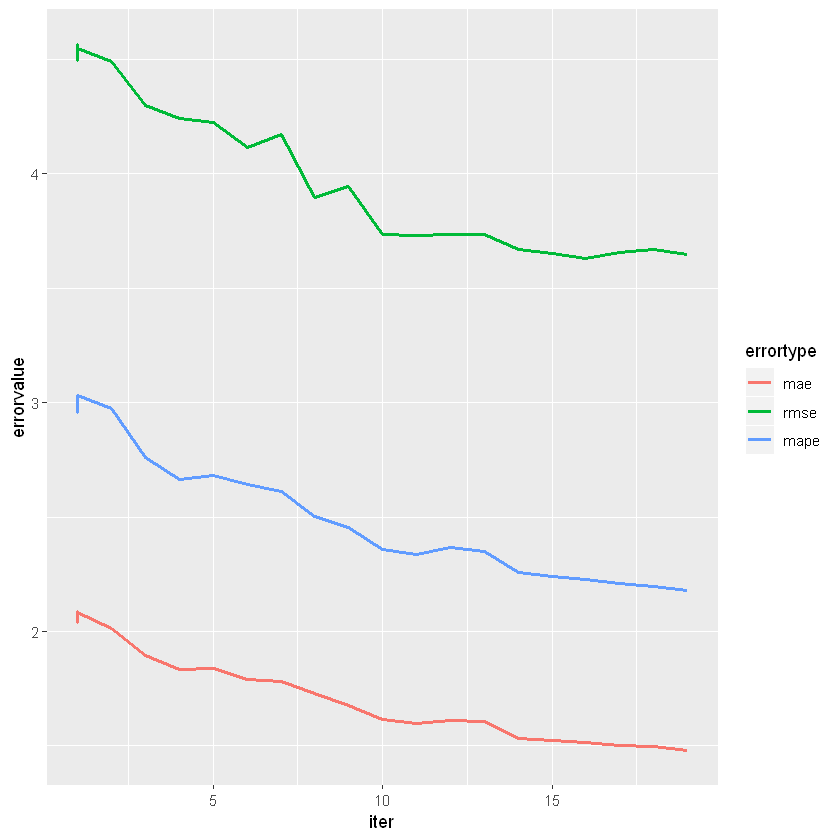

In [80]:
performance_molten_Ad <- melt(data = performance_table_Ad
                             , id.vars = 'iter')
setnames(performance_molten_Ad, c("variable","value"),c("errortype","errorvalue"))
p_Ad = ggplot(performance_molten_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1)
p_Ad

# Random Sampling vs Uncertainty Sampling

In [82]:
require(gridExtra)

Loading required package: gridExtra

Attaching package: 'gridExtra'

The following object is masked from 'package:randomForest':

    combine

The following object is masked from 'package:dplyr':

    combine



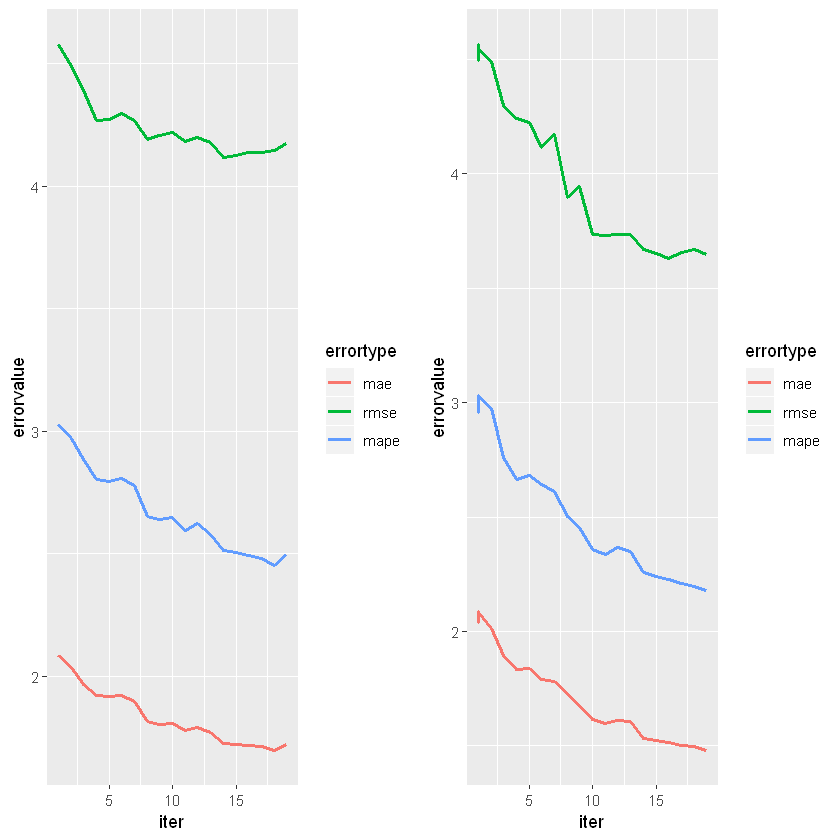

In [83]:
grid.arrange(p_Rd, p_Ad, ncol=2)

# Adaptive Sampling & Feature Elimination 

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [61]:
if(GenerateTTData == 1){
   
    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
    
    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
    setnames(LHSample_Ad, c("V1","V2"), feature_names)
    LHSample_Ad$output <- 0.00
    
    paste0("ABM run start time : ",Sys.time())
    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
    paste0("ABM run end time : ",Sys.time())
    
    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))

}else{
    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90  & `density` < 90],200)

}

### Visualization

In [ ]:
pca_LHSample_Ad <- princomp(LHSample_Ad[,-c("output")], cor = TRUE, scores = TRUE)

In [ ]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_Ad_components <- get_pca_ind(pca_LHSample_Ad)
pca_LHSample_Ad_components <-cbind(pca_LHSample_Ad_components$coord[,1:2],LHSample_Ad[,c("output")])
p_LHSample_Ad <- ggplot(data = pca_LHSample_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_LHSample_Ad

## Train and Test Metamodel

In [62]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )


In [63]:
#error_type = "mape"  
predictedLabels_table_AdFe = copy(test_set)

loop = 0
iter = 1
columns_left = feature_names
nofEliminatedVariables <- 0 # initial

print(Sys.time())
while(nofEliminatedVariables < nofparams){ # 1 is reponse v., another 1 is the last feature
    
    print(iter)
    loop =  loop + 1
    trainx = LHSample_Ad[,.SD, .SDcols = columns_left]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){
  #      importances <- importance(model_Sub, type = 1, scale = FALSE)
  #      selected.vars <- order(importances, decreasing = TRUE)
  #      ranked_features = feature_names[selected.vars]
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    if(iter == 1){
        obb_error <- as.data.table(obb_error_func(model_Sub)) 
        obb_error$iter <- 1 
        setnames(obb_error,"V1","obb_error")
    }else{
         ## OOB Error & Test Error 
        obb_error_Sub <- as.data.table(obb_error_func(model_Sub)) 
        obb_error_Sub$iter <- iter 
        obb_error <- rbind(obb_error,obb_error_Sub, use.names = FALSE)
        rm(obb_error_Sub)
    }
 

    
 #  ## OOB Error & Test Error 
 #  obb_error_Sub <- as.data.table(obb_error(model_Sub)) 
 #  obb_error_Sub$iter <- iter 
 #  obb_error_AdFe <- rbind(obb_error_AdFe,obb_error_Sub, use.names = FALSE)
 #  rm(obb_error_Sub)
  
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))  
    predictedLabels_table_AdFe = cbind(predictedLabels_table_AdFe,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table_temp = test_predictions_Sub[[2]]
    performance_table_temp[[1]] = iter
    performance_table = rbind(performance_table,performance_table_temp, use.names = FALSE)
    rm(performance_table_temp)   
    
    output_variables = test_predictions_Sub[[3]]          

if(nofEliminatedVariables < (nofparams - 1) ){ # 1 for output , 
    # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = sample_selection(selected_ins,unlabeled_set,trainx,trainy)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    print(paste0("ABM train_candidate run start time : ",Sys.time()))
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    print(paste0("ABM train_candidate run end time : ",Sys.time()))
    
    if(iter == 1){
        train_candidates_table <- copy(train_candidates)
        train_candidates_table$iter <- iter
    }else{
        train_candidates_temp <- copy(train_candidates)
        train_candidates_temp$iter <- iter
        
        train_candidates_table <- rbindlist(list(train_candidates_table,train_candidates_temp), use.names=TRUE)
        rm(train_candidates_temp)
    }

    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])
         
    # order columns according to importances
    id_variables = colnames(select(LHSample_Ad, -starts_with("pred_"))) # pred_ouput is always at the end
    LHSample_Ad = setcolorder(LHSample_Ad[,.SD, .SDcols = id_variables],ranked_features)
    
    # Apply feature elimination
    feature_elimination_result = feature_elimination(h,nofEliminatedVariables,LHSample_Ad,ranked_features)

    columns_left_iter = feature_elimination_result[[1]]# 
    eliminated_columns = setdiff(columns_left,columns_left_iter) ## bunu historik tut
    columns_left = copy(columns_left_iter)
    rm(columns_left_iter)
    
    nofEliminatedVariables = as.numeric(feature_elimination_result[2])                  

    
#   setcolorder(LHSample_Ad,selected.vars)
#    feature_elimination_result = feature_elimination(h,nofEliminatedVariables,LHSample_Ad,selected.vars)
    iter = iter + 1
    loop = loop + 1
  }
    
   if(loop > iter ){ break }   
}
print(Sys.time())
# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!

[1] 1
[1] 2


In [64]:
# Final records
FinalTrainData_AdFe = copy(LHSample_Ad)
performance_table_AdFe = copy(performance_table)
train_candidates_table_AdFe  = copy(train_candidates_table)
predictedLabels_table_AdFe = copy(predictedLabels_table)
obb_error_AdFe = copy(obb_error)

In [65]:
nrow(FinalTrainData_AdFe)
performance_table_AdFe
train_candidates_table_AdFe
head(predictedLabels_table_AdFe)
obb_error_AdFe

[1] 205

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,2.084766,4.571524,3.031850
2,6.250283,10.392718,8.991685


density,%-similar-wanted,idx,output,iter
<dbl>,<dbl>,<int>,<dbl>,<dbl>
66.09709,77.64091,427,56.54428,1
82.76068,76.43015,118,52.97802,1
72.41038,76.23947,160,54.78693,1
38.49721,77.71332,293,78.04716,1
10.75115,80.23808,431,100.00000,1


density,%-similar-wanted,output,pred_output_1,RMSE_1,pred_output_1.1,RMSE_1.1,pred_output_1.2,RMSE_1.2,pred_output_1.3,...,pred_output_15,RMSE_15,pred_output_16,RMSE_16,pred_output_17,RMSE_17,pred_output_18,RMSE_18,pred_output_19,RMSE_19
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.39026,63.87711,98.25157,98.02619,0.22537562,98.05625,0.195312276,98.07824,0.173327202,98.05447,...,97.65446,0.59711062,97.43004,0.82152704,97.76621,0.48535540,97.91883,0.332737480,97.65357,0.59799268
39.27182,36.46039,86.97693,84.78891,2.18801522,84.47239,2.504538564,84.53018,2.446747070,84.82991,...,87.29368,0.31675240,87.13750,0.16057395,87.26244,0.28551130,86.97396,0.002966766,87.10879,0.13186123
30.17455,57.23629,98.35179,98.40070,0.04891199,98.45743,0.105633999,98.46692,0.115129388,98.50400,...,98.41585,0.06405636,98.42143,0.06963919,98.47747,0.12568084,98.45857,0.106780124,98.44041,0.08861664
38.02617,15.93903,61.81402,63.55640,1.74238149,63.28558,1.471563231,63.02787,1.213856800,63.26405,...,62.65282,0.83880274,62.59872,0.78470151,62.60987,0.79584889,64.15607,2.342047583,64.13604,2.32202146
28.12210,68.05564,99.86504,99.87685,0.01181027,99.85945,0.005596987,99.86997,0.004930407,99.87220,...,99.87626,0.01121416,99.88544,0.02039341,99.87770,0.01265748,99.88128,0.016233152,99.87857,0.01352749
75.80979,17.80044,57.77487,58.20129,0.42642512,58.22111,0.446241064,58.34005,0.565177852,58.35384,...,57.98234,0.20747605,57.54364,0.23122477,57.41225,0.36261793,57.24022,0.534646247,57.46162,0.31324634


obb_error,iter
<dbl>,<dbl>
14.91404,1
128.74638,2


In [ ]:
#varImpPlot(model_Ad)

In [ ]:
NLQuit()